#TODO
1. sprawdzić zbalansowanie datasetów; poprawić w razie konieczności
2. klasyfikacja; wybrać klasyfikatory i puścić na datasetach
3. syntetyczny zbiór danych???

In [461]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.decomposition import SparsePCA
from sklearn.decomposition import KernelPCA
from sklearn.decomposition import NMF

from L1PCA import l1pca
from utilities import one_hot

BREAST_PATH = '../data/breast.csv'
HR_PATH = '../data/human_resources.csv'
SONAR_PATH = '../data/sonar.csv'
SPAM_PATH = '../data/spam.csv'
SMOKING_PATH = '../data/smoking.csv'

dataset_paths = [HR_PATH, BREAST_PATH] #SMOKING_PATH, SPAM_PATH, SONAR_PATH

In [425]:
"""
Spam base dataset
"""
def init_spam():
    dataset_name = "spam"
    spam_features = ['word_freq_make','word_freq_address','word_freq_all','word_freq_3d','word_freq_our','word_freq_over','word_freq_remove','word_freq_internet','word_freq_order','word_freq_mail','word_freq_receive','word_freq_will','word_freq_people','word_freq_report','word_freq_addresses','word_freq_free','word_freq_business','word_freq_email','word_freq_you','word_freq_credit','word_freq_your','word_freq_font','word_freq_000','word_freq_money','word_freq_hp','word_freq_hpl','word_freq_george','word_freq_650','word_freq_lab','word_freq_labs','word_freq_telnet','word_freq_857','word_freq_data','word_freq_415','word_freq_85','word_freq_technology','word_freq_1999','word_freq_parts','word_freq_pm','word_freq_direct','word_freq_cs','word_freq_meeting','word_freq_original','word_freq_project','word_freq_re','word_freq_edu','word_freq_table','word_freq_conference','char_freq_;','char_freq_(','char_freq_[','char_freq_!','char_freq_$','char_freq_#','capital_run_length_average','capital_run_length_longest','capital_run_length_total','label']
    spam_dataset = pd.read_csv(f"../raw_data/{dataset_name}.csv", header=None)
    spam_dataset.columns=spam_features
    spam_dataset.to_csv(SPAM_PATH, index = False)

"""
Sonar dataset
"""
def init_sonar():
    dataset_name = "sonar"
    sonar_dataset = pd.read_csv(f"../raw_data/{dataset_name}.csv", names = range(0,61))
    sonar_dataset.rename(columns={60:'label'}, inplace=True)
    sonar_dataset['label'].replace(0, 'R',inplace=True)
    sonar_dataset['label'].replace(1, 'M',inplace=True)
    sonar_dataset.to_csv(SONAR_PATH, index = False)

"""
Smoking dataset
"""
def init_smoking():
    smoking_dataset = pd.read_csv(f"../raw_data/smoking.csv")
    smoking_dataset = smoking_dataset.drop(['ID'], axis=1)
    smoking_dataset_label = smoking_dataset.pop('smoking')
    smoking_dataset = one_hot(smoking_dataset, 'gender')
    smoking_dataset = one_hot(smoking_dataset, 'oral')
    smoking_dataset.rename(columns={'Y':'oral'}, inplace=True)
    smoking_dataset = one_hot(smoking_dataset, 'tartar')
    smoking_dataset.rename(columns={'Y':'tartar'}, inplace=True)
    smoking_dataset.rename(columns={'N':'no_tartar'}, inplace=True)
    smoking_dataset.insert(len(smoking_dataset.columns), 'smoking', smoking_dataset_label)
    smoking_dataset.to_csv(SMOKING_PATH, index = False)
    

"""
Human resources dataset
"""
def init_hr():
    dataset_name = "human_resources"
    hr_dataset = pd.read_csv(f"../raw_data/{dataset_name}.csv")
    hr_labels = hr_dataset.pop('left')
    hr_dataset.rename(columns={'sales':'department'}, inplace=True)
    hr_dataset = one_hot(hr_dataset, 'salary')
    hr_dataset = one_hot(hr_dataset, 'department')
    hr_dataset.insert(len(hr_dataset.columns), 'left', hr_labels)
    hr_dataset.to_csv(HR_PATH, index = False)
    
"""
Breast dataset
"""
def init_breast():
       breast_dataset = pd.DataFrame(pd.read_csv(f"../raw_data/breast.csv"))
       breast_labels = breast_dataset.pop('diagnosis')
       breast_dataset.drop(columns=(['id', 'Unnamed: 32']), inplace=True)
       breast_dataset.insert(len(breast_dataset.columns), 'diagnosis', breast_labels)
       breast_dataset.to_csv(BREAST_PATH, index = False)


In [426]:
init_hr()
init_smoking()
init_breast()
init_spam()
init_sonar()

In [427]:
def standardize_dataset(path):
    data = pd.read_csv(path)
    features = list(data.columns[:-1])
    x = data.loc[:, features].values
    x = StandardScaler().fit_transform(x)
    return x

def normalize_dataset(path):
    data = pd.read_csv(path)
    features = list(data.columns[:-1])
    x = data.loc[:, features].values
    x = MinMaxScaler().fit_transform(x)
    return x

In [428]:
def l1pca_transform(path, n):
    data = pd.read_csv(path)
    features = list(data.columns[:-1])
    x = data.loc[:, features].values
    principal_components = l1pca(x, n)
    return principal_components

def pca_transform(path, n):
    n = int(n)
    standardized_data = standardize_dataset(path)
    pca = PCA(n_components=n)
    principal_components = pca.fit_transform(standardized_data)
    print(f'EXPLAINED VARIANCE RATIO:\t{np.around(pca.explained_variance_ratio_, decimals=3)}\nINFORMATION LOSS:\t\t{1-sum(pca.explained_variance_ratio_):.3}')
    return principal_components

def kernel_pca_transform(path, n):
    standardized_data = standardize_dataset(path)
    kernel_pca = KernelPCA(n_components=n)
    principal_components = kernel_pca.fit_transform(standardized_data)
    return principal_components

def sparse_pca_transform(path, n):
    standardized_data = standardize_dataset(path)
    sparse_pca = SparsePCA(n_components=n)
    principal_components = sparse_pca.fit_transform(standardized_data)
    return principal_components

def nmf_transform(path, n):
    normalized_data = normalize_dataset(path)
    nmf = NMF(n_components=n, max_iter=20000, init='random')
    components = nmf.fit_transform(normalized_data)
    return components

pca			../data/human_resources.csv
EXPLAINED VARIANCE RATIO:	[0.094 0.091]
INFORMATION LOSS:		0.815

kernel_pca			../data/human_resources.csv
sparse_pca			../data/human_resources.csv
nmf			../data/human_resources.csv
pca			../data/breast.csv
EXPLAINED VARIANCE RATIO:	[0.443 0.19 ]
INFORMATION LOSS:		0.368

kernel_pca			../data/breast.csv
sparse_pca			../data/breast.csv
nmf			../data/breast.csv
pca			../data/spam.csv
EXPLAINED VARIANCE RATIO:	[0.115 0.058]
INFORMATION LOSS:		0.827

kernel_pca			../data/spam.csv
sparse_pca			../data/spam.csv
nmf			../data/spam.csv
pca			../data/sonar.csv
EXPLAINED VARIANCE RATIO:	[0.203 0.189]
INFORMATION LOSS:		0.608

kernel_pca			../data/sonar.csv
sparse_pca			../data/sonar.csv
nmf			../data/sonar.csv


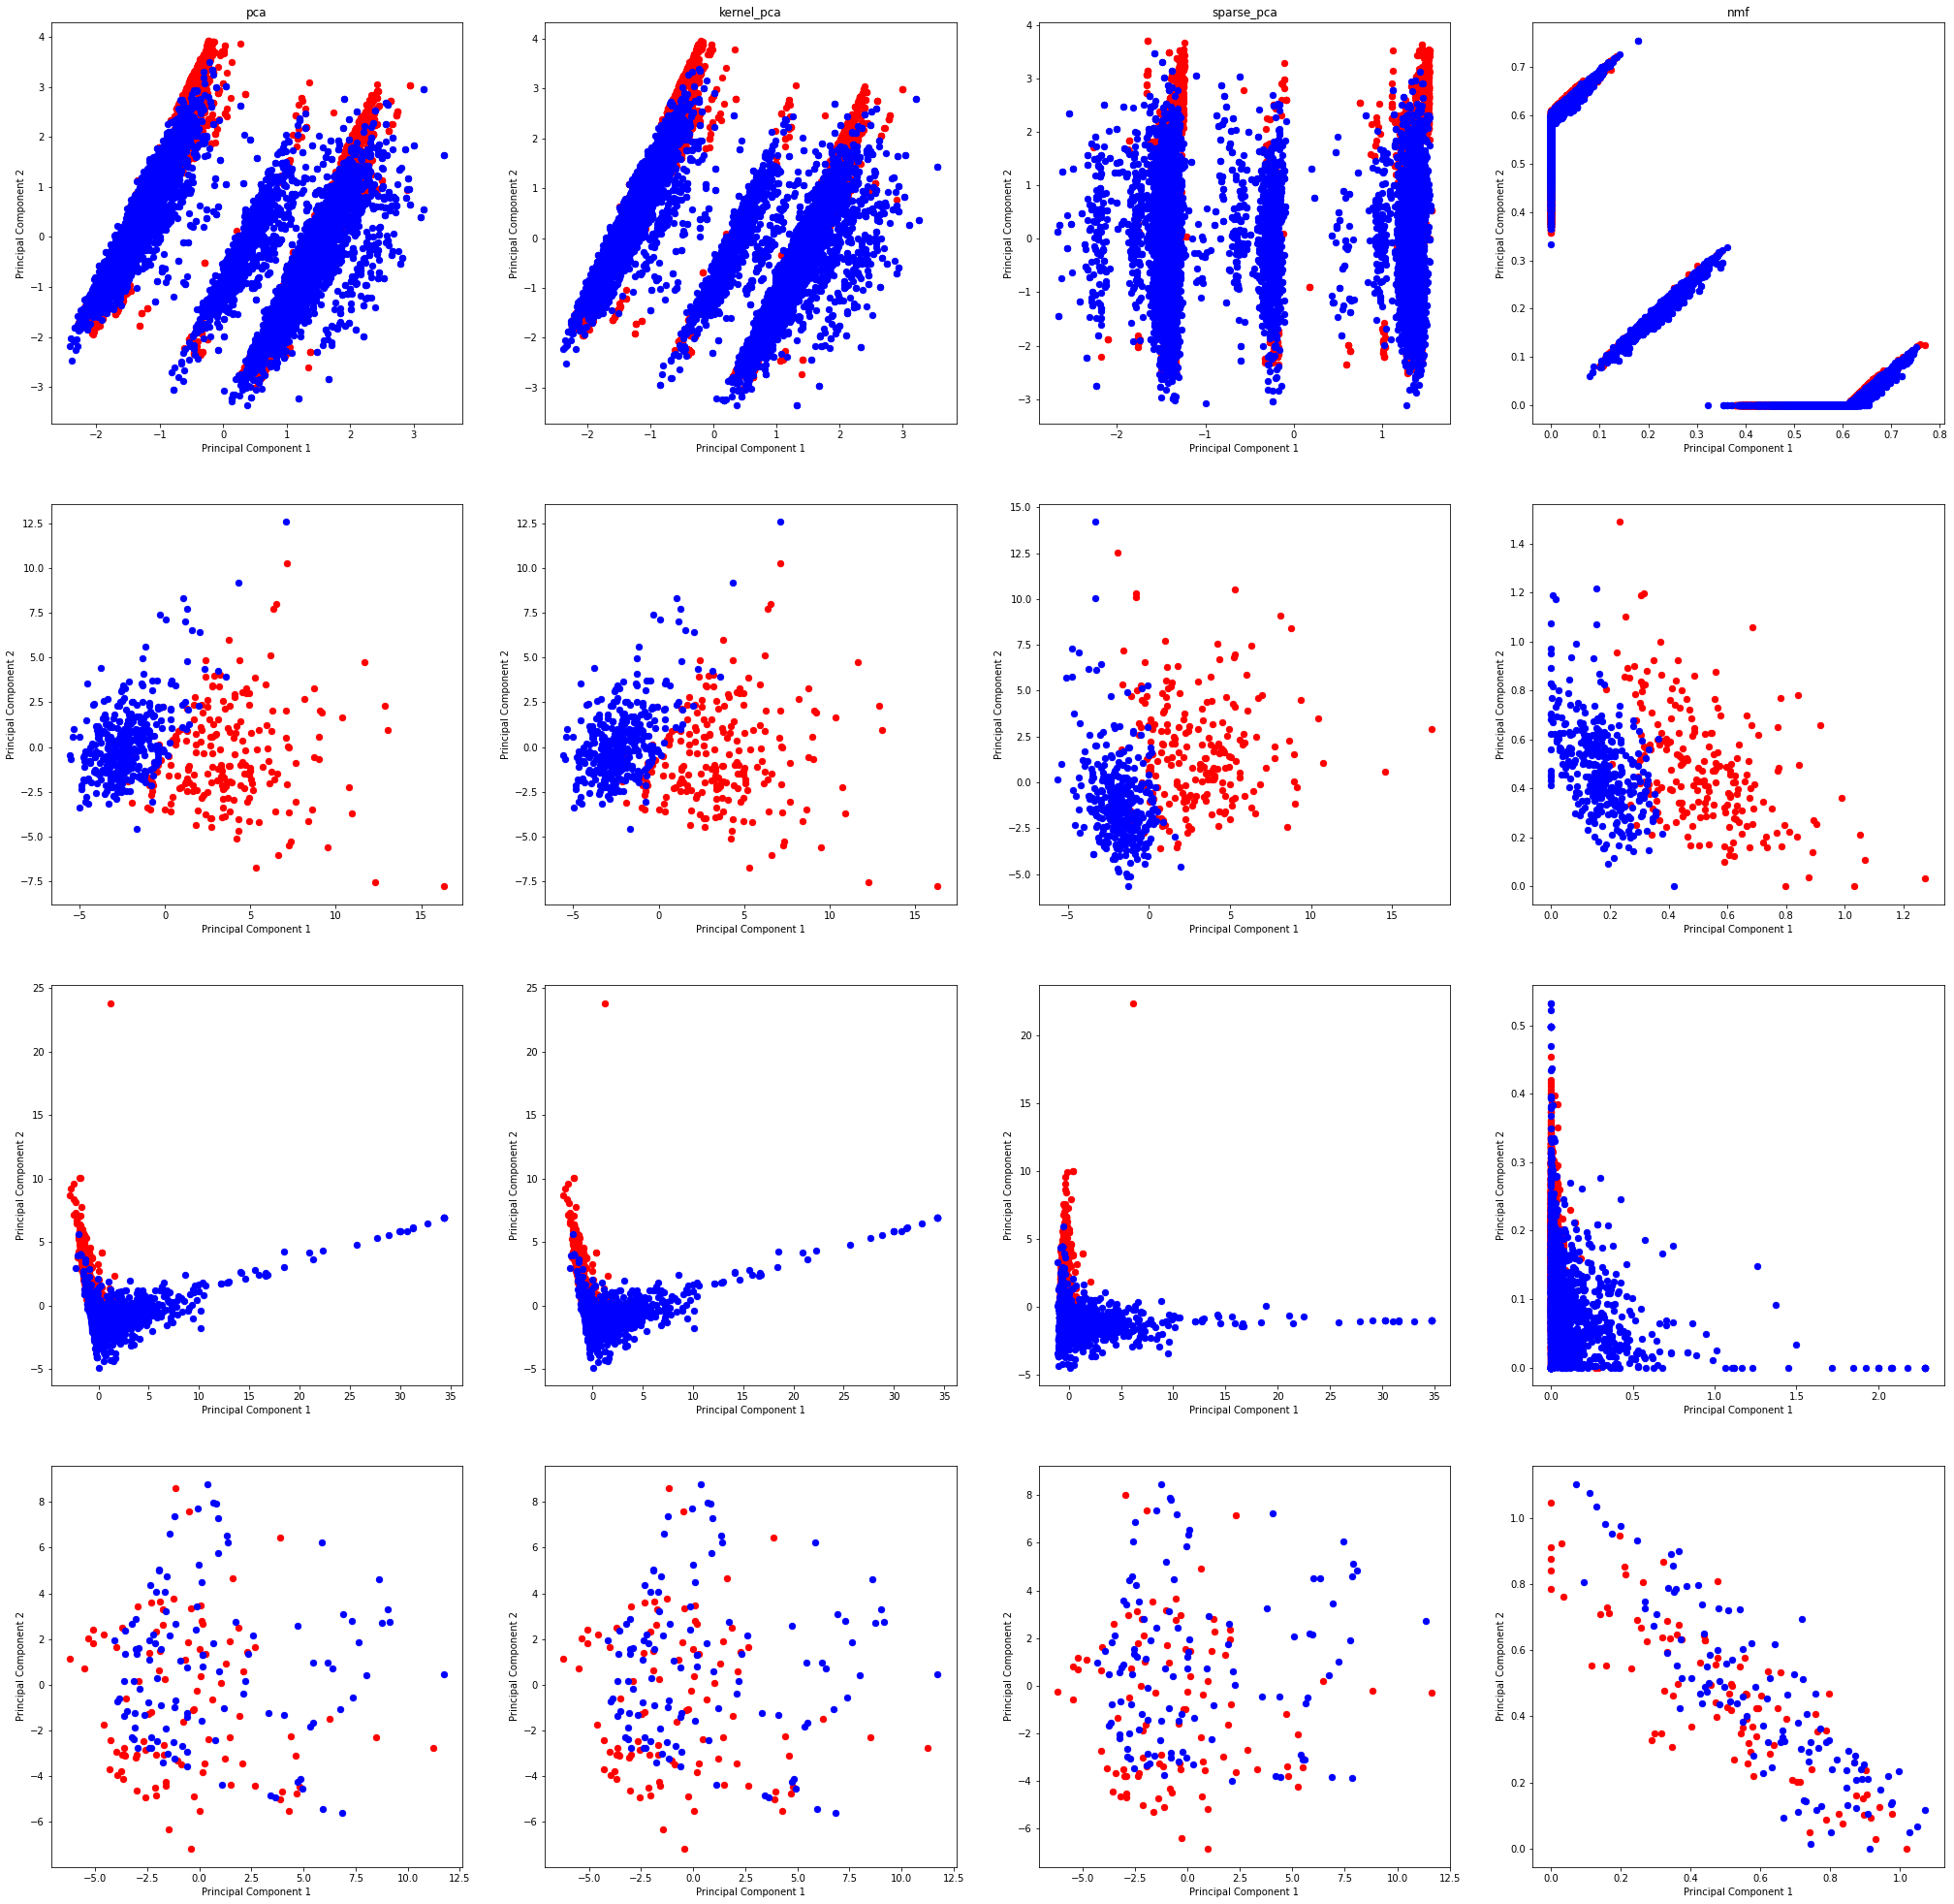

In [429]:
def draw_2d_plots():
    features_to_keep = 2
    methods = {
        'pca': pca_transform,
        'kernel_pca': kernel_pca_transform,
        'sparse_pca': sparse_pca_transform,
        'nmf': nmf_transform
    } # l1pca
    fig, axs = plt.subplots(len(dataset_paths), len(methods), figsize=(35,35))

    for row, path in enumerate(dataset_paths):
        dataset = pd.read_csv(path)
        targets = dataset[dataset.columns[-1]].unique()
        colors = ['r', 'b']
        for column, method in enumerate(methods):
            if row == 0:
                axs[row,column].set_title(method)

            print(f"{method} --- --- --- {path}")
            components = ([f'principal component {i+1}' for i in range(features_to_keep)])
            dataframe = pd.DataFrame(data = methods[method](path, features_to_keep), columns=components)
            
            for (target, color) in zip(targets,colors):
                indicesToKeep = pd.read_csv(path)[dataset.columns[-1]] == target
                axs[row, column].scatter(dataframe.loc[indicesToKeep, 'principal component 1'], dataframe.loc[indicesToKeep, 'principal component 2'], c = color, s = 40)

    for ax in axs.flat:
        ax.set(xlabel='Principal Component 1', ylabel='Principal Component 2')

draw_2d_plots()

In [459]:
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import RepeatedStratifiedKFold

clfs = {
    'GNB': GaussianNB(),
    # 'SVM': SVC(),
    # 'kNN': KNeighborsClassifier(),
    # 'CART': DecisionTreeClassifier(random_state=1410),
}

n_datasets = len(dataset_paths)
n_splits = 5
n_repeats = 2
rskf = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=1234)

scores = np.zeros((len(clfs), n_datasets, n_repeats*n_splits))

In [462]:
from sklearn.base import clone
from sklearn.metrics import accuracy_score


for data_id, dataset in enumerate(dataset_paths):
    dataset = np.genfromtxt(dataset, delimiter=",")
    print(dataset)
    X = dataset[1:, :-1]
    y = dataset[1:, -1].astype(int)


    for fold_id, (train, test) in enumerate(rskf.split(X, y)):
        for clf_id, clf_name in enumerate(clfs):
            clf = clone(clfs[clf_name])
            clf.fit(X[train], y[train])
            y_pred = clf.predict(X[test])
            scores[clf_id, data_id, fold_id] = accuracy_score(y[test], y_pred)

np.save('results', scores)

[[ nan  nan  nan ...  nan  nan  nan]
 [0.38 0.53 2.   ... 0.   0.   1.  ]
 [0.8  0.86 5.   ... 0.   0.   1.  ]
 ...
 [0.37 0.53 2.   ... 1.   0.   1.  ]
 [0.11 0.96 6.   ... 1.   0.   1.  ]
 [0.37 0.52 2.   ... 1.   0.   1.  ]]


GaussianNB()

GaussianNB()

GaussianNB()

GaussianNB()

GaussianNB()

GaussianNB()

GaussianNB()

GaussianNB()

GaussianNB()

GaussianNB()

[[      nan       nan       nan ...       nan       nan       nan]
 [1.799e+01 1.038e+01 1.228e+02 ... 4.601e-01 1.189e-01       nan]
 [2.057e+01 1.777e+01 1.329e+02 ... 2.750e-01 8.902e-02       nan]
 ...
 [1.660e+01 2.808e+01 1.083e+02 ... 2.218e-01 7.820e-02       nan]
 [2.060e+01 2.933e+01 1.401e+02 ... 4.087e-01 1.240e-01       nan]
 [7.760e+00 2.454e+01 4.792e+01 ... 2.871e-01 7.039e-02       nan]]


GaussianNB()

IndexError: index 1 is out of bounds for axis 1 with size 1